# Sequence Models & How to use them

**학습목표**
1. Bidirectional layer를 이해한다.
2. Bidirectional layer를 사용할 줄 안다.

-----------------
* Thanks to : 한기영 대표님 @ Data Insight

## 1.환경 및 데이터 준비

### Import Packages

In [28]:
#라이브러리들을 불러오자.
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten, SimpleRNN, LSTM, GRU
from tensorflow.keras.layers import Bidirectional, Conv1D, MaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.backend import clear_session
from sklearn.metrics import mean_absolute_error as MSE

import matplotlib.pyplot as plt

### Data Loading

In [29]:
url = 'https://raw.githubusercontent.com/RayleighKim/Example_datasets/master/Stock_Edwards_Lifesciences_corporation.csv'

# 판다스로 데이터를 불러오시오.
data = pd.read_csv(url)

In [30]:
print(data.shape)
data.head()

(4392, 7)


,Date,Open,High,Low,Close,Adj_Close,Volume
0,2000/3/27,3.812500,4.156250,3.812500,4.125000,4.125000,3675600
1,2000/3/28,4.125000,4.125000,4.000000,4.015625,4.015625,1077600
2,2000/3/29,4.000000,4.031250,3.953125,4.000000,4.000000,437200
3,2000/3/30,4.000000,4.000000,3.843750,3.843750,3.843750,1883600
4,2000/3/31,3.734375,3.734375,3.390625,3.390625,3.390625,7931600


##3.데이터 준비

### Date 컬럼을 제거하시오.

In [31]:
data = data.drop(['Date'], axis=1)
data.head()

,Open,High,Low,Close,Adj_Close,Volume
0,3.812500,4.156250,3.812500,4.125000,4.125000,3675600
1,4.125000,4.125000,4.000000,4.015625,4.015625,1077600
2,4.000000,4.031250,3.953125,4.000000,4.000000,437200
3,4.000000,4.000000,3.843750,3.843750,3.843750,1883600
4,3.734375,3.734375,3.390625,3.390625,3.390625,7931600


## 4.Sequence 데이터 구조로 만들기

**조건**
* 내일의 Close를 예측할 것이다. 이를 Y로 둘 것.
* timestep은 10주를 본다. (주식은 5일이 1주일)
* 맞추어 전처리

**데이터 분할 규칙**
* 가장 최근 1주일을 테스트 데이터로 둔다.
* 테스트 데이터를 제외하고, 가장 최근 2주를 벨리데이션 데이터로 둔다.

In [32]:
# 판다스 데이터 프레임을 넘파이로 옮김.
data = data.values

In [33]:
# 여기에 의미있는 기간(timestep을 지정해 봅시다.)
timestep= 5 * 10

x = np.array([data[i : i + timestep, :] for i in range(len(data) - timestep)])
y = np.array([data[i + timestep, -3] for i in range(len(data) - timestep)])

x_train, x_val, x_test = x[:-15], x[-15 : -5], x[-5:]
y_train, y_val, y_test = y[:-15], y[-15 : -5], y[-5:]

## 모양 확인 필수
print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(4327, 50, 6) (10, 50, 6) (5, 50, 6)
(4327,) (10,) (5,)


데이터의 구조 : [n, timestep, feature수]

# 같이 해보기
**[참고링크](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional)**
1. 적절한 인풋 레이어를 구성할 것
2. Conv1D
    * 16개 필터 사용할 것
    * window_size(filter_size)는 5일
    * activation은 swish
3. MaxPool1D
    * 필터 사이즈(window size)는 2일
4. Bidirectional 레이어
    * LSTM, 히든스테이트 노드 32개
5. Bidirectional 레이어
    * LSTM, 히든스테이트 노드 32개
4. 플래튼
5. 회귀를 위한 적절한 아웃풋 레이어



In [34]:
####################
## Your Code Here ##
####################

# 세션 클리어
clear_session()

# 모델 쌓기
# 1. 적절한 인풋 레이어를 구성할 것
il = Input(shape=(timestep, 6))

# 2. Conv1D
#     * 16개 필터 사용할 것
#     * window_size(filter_size)는 5일
#     * activation은 swish
hl = Conv1D(16, kernel_size=5, activation='swish', padding='same')(il)

# 3. MaxPool1D
#     * 필터 사이즈(window size)는 2일
hl = MaxPool1D(2)(hl)

# 4. Bidirectional 레이어
#     * LSTM, 히든스테이트 노드 32개
hl = Bidirectional(layer=LSTM(32, return_sequences=True))(hl)

# 5. Bidirectional 레이어
#     * LSTM, 히든스테이트 노드 32개
hl = Bidirectional(layer=LSTM(32, return_sequences=True))(hl)

# 4. 플래튼
hl = Flatten()(hl)

# 5. 회귀를 위한 적절한 아웃풋 레이어
ol = Dense(1, activation='relu')(hl)

# 모델 선언
model = Model(il, ol)

# 컴파일
model.compile(loss='mse', optimizer='adam')

# 요약
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 6)]           0         
                                                                 
 conv1d (Conv1D)             (None, 50, 16)            496       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 25, 16)           0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 25, 64)           12544     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 25, 64)           24832     
 nal)                                                            
                                                             

In [35]:
## 학습도 시킬 것
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10)

Epoch 1/10
136/136 [==============================] - 16s 59ms/step - loss: 961.4455 - val_loss: 6268.7021
Epoch 2/10
136/136 [==============================] - 5s 40ms/step - loss: 878.3171 - val_loss: 6661.9492
Epoch 3/10
136/136 [==============================] - 6s 47ms/step - loss: 866.7168 - val_loss: 6597.5688
Epoch 4/10
136/136 [==============================] - 6s 41ms/step - loss: 855.1470 - val_loss: 6480.1035
Epoch 5/10
136/136 [==============================] - 6s 48ms/step - loss: 879.7136 - val_loss: 6657.0322
Epoch 6/10
136/136 [==============================] - 6s 41ms/step - loss: 875.1273 - val_loss: 6197.7119
Epoch 7/10
136/136 [==============================] - 8s 55ms/step - loss: 868.4501 - val_loss: 7027.7876
Epoch 8/10
136/136 [==============================] - 6s 41ms/step - loss: 832.8260 - val_loss: 5838.0967
Epoch 9/10
136/136 [==============================] - 7s 48ms/step - loss: 883.5745 - val_loss: 7455.0991
Epoch 10/10
136/136 [========================

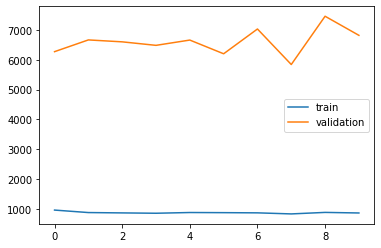

In [36]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [37]:
# Q1. 테스트 셋에서의 RMSE를 출력하여라.
y_pred = model.predict(x_test)
print(f'RMSE : {MSE(y_test, y_pred) ** 0.5}')

1/1 [==============================] - 2s 2s/step
RMSE : 9.050925937063726


## Q1. Conv1D + Bidirectional

**[공식문서 적극 참고](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional)**
Bidirectional)**
1. 적절한 인풋 레이어를 구성할 것
2. Conv1D
    * 32개 필터 사용할 것
    * window_size(filter_size)는 10일
    * activation은 swish
3. MaxPool1D
    * 필터 사이즈(window size)는 2일
4. Bidirectional 레이어
    * forward layer : LSTM, 히든스테이트 노드 24개
    * backward layer : GRU, 히든스테이트 노드 16개
4. Bidirectional 레이어
    * forward layer : LSTM, 히든스테이트 노드 24개
    * backward layer : GRU, 히든스테이트 노드 24개
4. 플래튼
6. Fully Connected : 노드 256개, swish
5. 회귀를 위한 적절한 아웃풋 레이어


In [38]:
####################
## Your Code Here ##
####################

# 세션 클리어
clear_session()

# 적절한 인풋 레이어를 구성할 것
il = Input(shape=(timestep, 6))

# Conv1D
# 32개 필터 사용할 것
# window_size(filter_size)는 10일
# activation은 swish
hl = Conv1D(32, kernel_size=10, activation='swish', padding='same')(il)

# MaxPool1D
# 필터 사이즈(window size)는 2일
hl = MaxPool1D(2)(hl)

# Bidirectional 레이어
# forward layer : LSTM, 히든스테이트 노드 24개
# backward layer : GRU, 히든스테이트 노드 16개
forward_LSTM = LSTM(24, return_sequences=True)
backward_GRU = GRU(16, return_sequences=True, go_backwards=True)
hl = Bidirectional(layer=forward_LSTM, backward_layer=backward_GRU)(hl)

# Bidirectional 레이어
# forward layer : LSTM, 히든스테이트 노드 24개
# backward layer : GRU, 히든스테이트 노드 24개
forward_LSTM = LSTM(24, return_sequences=True)
backward_GRU = GRU(24, return_sequences=True, go_backwards=True)
hl = Bidirectional(layer=forward_LSTM, backward_layer=backward_GRU)(hl)

# 플래튼
hl = Flatten()(hl)

# Fully Connected : 노드 256개, swish
hl = Dense(256, activation='swish')(hl)

# 회귀를 위한 적절한 아웃풋 레이어
ol = Dense(1, activation='relu')(hl)

# 모델 선언
model = Model(il, ol)

# 컴파일
model.compile(loss='mse', optimizer='adam')

# 요약
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 6)]           0         
                                                                 
 conv1d (Conv1D)             (None, 50, 32)            1952      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 25, 32)           0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 25, 40)           7872      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 25, 48)           10992     
 nal)                                                            
                                                             

In [39]:
## 학습도 시킬 것
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10)

Epoch 1/10
136/136 [==============================] - 18s 67ms/step - loss: 894.4559 - val_loss: 7238.3779
Epoch 2/10
136/136 [==============================] - 7s 54ms/step - loss: 870.9888 - val_loss: 6003.5835
Epoch 3/10
136/136 [==============================] - 7s 49ms/step - loss: 864.9458 - val_loss: 6585.1704
Epoch 4/10
136/136 [==============================] - 7s 55ms/step - loss: 874.3629 - val_loss: 6821.7266
Epoch 5/10
136/136 [==============================] - 8s 61ms/step - loss: 874.9218 - val_loss: 5236.1948
Epoch 6/10
136/136 [==============================] - 7s 48ms/step - loss: 876.5584 - val_loss: 5363.2588
Epoch 7/10
136/136 [==============================] - 7s 54ms/step - loss: 881.0178 - val_loss: 6658.0024
Epoch 8/10
136/136 [==============================] - 6s 47ms/step - loss: 872.7303 - val_loss: 6564.8999
Epoch 9/10
136/136 [==============================] - 7s 54ms/step - loss: 881.4805 - val_loss: 5524.5718
Epoch 10/10
136/136 [========================

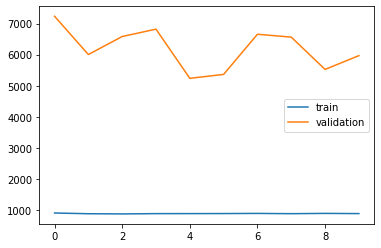

In [40]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [41]:
# Q1. 테스트 셋에서의 RMSE를 출력하여라.
y_pred = model.predict(x_test)
print(f'RMSE : {MSE(y_test, y_pred) ** 0.5}')

1/1 [==============================] - 2s 2s/step
RMSE : 8.825988635668429


---
# 강사님 예시 코드

In [1]:
from tensorflow.keras.layers import Input, Dense, Flatten, SimpleRNN, LSTM, GRU
from tensorflow.keras.layers import Bidirectional, Conv1D, MaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.backend import clear_session

In [6]:
clear_session()

il = Input(shape=(20, 6))

hl = Conv1D(16, kernel_size=5, activation='relu', padding='same')(il)
hl = Conv1D(16, kernel_size=5, activation='relu', padding='same')(hl)
hl = MaxPool1D(2)(hl)
hl = Bidirectional(layer=LSTM(32, return_sequences=True))(hl)

forward_gru = GRU(32, return_sequences=True)
backward_LSTM = LSTM(24, return_sequences=True, go_backwards=True)
hl = Bidirectional(layer=forward_gru, backward_layer=backward_LSTM)(hl)

ol = Dense(1, activation='relu')(hl)

model = Model(il, ol)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 6)]           0         
                                                                 
 conv1d (Conv1D)             (None, 20, 16)            496       
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 16)            1296      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 16)           0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 10, 64)           12544     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 10, 56)           17952 